# TEDAI-224 : Classify buyer according to its expenditure over a period of time

Dataset available at: s3://d-ew1-ted-ai-experiments-data/budgetary-values/20230818-tedai-224-dataset_buyers.csv

In [1]:
from ast import literal_eval
import pandas as pd


df = pd.read_csv('dataset_buyer/20230818-tedai-224-dataset_buyers.csv', converters={"buyer": literal_eval, "budgetary_values": literal_eval})
# Flatten json buyer field
df['buyer_name'] = df.apply(lambda x : x.buyer.get("name"), axis=1)
df['buyer_address'] = df.apply(lambda x : x.buyer.get("address"), axis=1)
df['buyer_town'] = df.apply(lambda x : x.buyer.get("town"), axis=1)
df['buyer_postal_code'] = df.apply(lambda x : x.buyer.get("postal_code"), axis=1)
df = df.drop('buyer', axis=1)
df.tail()

id   ingestion_type  main_cpv additional_cpvs country  \
44856  238949-2016  contract_notice  24000000             NaN     BEL   
44857  243990-2016  contract_notice  73000000             NaN     GRC   
44858  243983-2016  contract_notice  71317200             NaN     FRA   
44859  242324-2016  contract_notice  73210000             NaN     LTU   
44860  246831-2016  contract_notice  35100000             NaN     BEL   

                                        budgetary_values  \
44856  [{'type': 'PROCUREMENT', 'lot': '', 'estimated...   
44857  [{'type': 'PROCUREMENT', 'lot': '', 'estimated...   
44858  [{'type': 'PROCUREMENT', 'lot': '', 'estimated...   
44859  [{'type': 'PROCUREMENT', 'lot': '', 'estimated...   
44860  [{'type': 'PROCUREMENT', 'lot': '', 'estimated...   

                                              buyer_name  \
44856  European Commission, Directorate-General for I...   
44857  Cedefop — European Centre for the Development ...   
44858                                                      
44859             European Institute for Gender Equality   
44860                                     European Union   

                            buyer_address    buyer_town buyer_postal_code  
44856  avenue d'Auderghem 45, BREY 12/088      Brussels              1049  
44857     Europe Street 123, PO Box 22427  Thessaloniki            551 02  
44858                                                                      
44859                     Gedimino pr. 16       Vilnius             01103  
44860                                          Brussels

In [2]:
from currency_converter import CurrencyConverter, SINGLE_DAY_ECB_URL
currency_converter = CurrencyConverter(SINGLE_DAY_ECB_URL)


def _extract_budgetary_value_from_procurement(list_of_budgetary_values):
    for element in list_of_budgetary_values:
        budgetary_value = None
        if element.get("type") == "PROCUREMENT":

            min_value = element.get("min_value")
            min_value_currency = element.get("min_value_currency", 'EUR')
            if min_value and float(min_value) > 0:
                budgetary_value = float(min_value)
                currency_budget = min_value_currency

            max_value = element.get("max_value")
            max_value_currency = element.get("max_value_currency", 'EUR')
            if max_value and float(max_value) > 0:
                budgetary_value = float(max_value)
                currency_budget = max_value_currency

            estimated_value = element.get("estimated_value")
            estimated_value_currency = element.get("estimated_value_currency", 'EUR')

            if estimated_value and float(estimated_value) > 0:
                budgetary_value = float(estimated_value)
                currency_budget = estimated_value_currency

            if budgetary_value:
                if currency_budget != "EUR":
                    try:
                        budgetary_value = currency_converter.convert(budgetary_value, currency_budget, "EUR")
                    except:
                        return None
                return budgetary_value
            

    return None


# Flatten json budgetary_values field
df['budgetary_value'] = df.apply(lambda x : _extract_budgetary_value_from_procurement(x.budgetary_values), axis=1)
df = df.drop('budgetary_values', axis=1)
df.tail()

id   ingestion_type  main_cpv additional_cpvs country  \
44856  238949-2016  contract_notice  24000000             NaN     BEL   
44857  243990-2016  contract_notice  73000000             NaN     GRC   
44858  243983-2016  contract_notice  71317200             NaN     FRA   
44859  242324-2016  contract_notice  73210000             NaN     LTU   
44860  246831-2016  contract_notice  35100000             NaN     BEL   

                                              buyer_name  \
44856  European Commission, Directorate-General for I...   
44857  Cedefop — European Centre for the Development ...   
44858                                                      
44859             European Institute for Gender Equality   
44860                                     European Union   

                            buyer_address    buyer_town buyer_postal_code  \
44856  avenue d'Auderghem 45, BREY 12/088      Brussels              1049   
44857     Europe Street 123, PO Box 22427  Thessaloniki            551 02   
44858                                                                       
44859                     Gedimino pr. 16       Vilnius             01103   
44860                                          Brussels                     

       budgetary_value  
44856         150000.0  
44857         330000.0  
44858         100000.0  
44859         585000.0  
44860              NaN

In [3]:
def _merge_cpvs(main_cpv, additional_cpvs):
    main_cpv = str(main_cpv)
    if len(main_cpv) < 8:
        main_cpv = "0" + main_cpv
    all_cpvs = [main_cpv]
    if additional_cpvs and isinstance(additional_cpvs, str):
        additional_cpvs_list = additional_cpvs.split(",")
        all_cpvs.extend(additional_cpvs_list)

    return list(set(all_cpvs))

df['cpvs'] = df.apply(lambda x : _merge_cpvs(x.main_cpv, x.additional_cpvs), axis=1)

df = df.drop('main_cpv', axis=1)
df = df.drop('additional_cpvs', axis=1)
df.tail()

id   ingestion_type country  \
44856  238949-2016  contract_notice     BEL   
44857  243990-2016  contract_notice     GRC   
44858  243983-2016  contract_notice     FRA   
44859  242324-2016  contract_notice     LTU   
44860  246831-2016  contract_notice     BEL   

                                              buyer_name  \
44856  European Commission, Directorate-General for I...   
44857  Cedefop — European Centre for the Development ...   
44858                                                      
44859             European Institute for Gender Equality   
44860                                     European Union   

                            buyer_address    buyer_town buyer_postal_code  \
44856  avenue d'Auderghem 45, BREY 12/088      Brussels              1049   
44857     Europe Street 123, PO Box 22427  Thessaloniki            551 02   
44858                                                                       
44859                     Gedimino pr. 16       Vilnius             01103   
44860                                          Brussels                     

       budgetary_value        cpvs  
44856         150000.0  [24000000]  
44857         330000.0  [73000000]  
44858         100000.0  [71317200]  
44859         585000.0  [73210000]  
44860              NaN  [35100000]

In [4]:
df = df.dropna(subset=['budgetary_value'])
df.tail()

id   ingestion_type country  \
44855  238930-2016  contract_notice     LUX   
44856  238949-2016  contract_notice     BEL   
44857  243990-2016  contract_notice     GRC   
44858  243983-2016  contract_notice     FRA   
44859  242324-2016  contract_notice     LTU   

                                              buyer_name  \
44855  Translation Centre for the Bodies of the Europ...   
44856  European Commission, Directorate-General for I...   
44857  Cedefop — European Centre for the Development ...   
44858                                                      
44859             European Institute for Gender Equality   

                                     buyer_address    buyer_town  \
44855  Drosbach Building, 12E, rue Guillaume Kroll    Luxembourg   
44856           avenue d'Auderghem 45, BREY 12/088      Brussels   
44857              Europe Street 123, PO Box 22427  Thessaloniki   
44858                                                              
44859                              Gedimino pr. 16       Vilnius   

      buyer_postal_code  budgetary_value        cpvs  
44855              1882          25000.0  [79530000]  
44856              1049         150000.0  [24000000]  
44857            551 02         330000.0  [73000000]  
44858                           100000.0  [71317200]  
44859             01103         585000.0  [73210000]

In [5]:
df["buyer_name"].value_counts()

buyer_name
                                                                                                                                 808
European Parliament                                                                                                              702
European Commission                                                                                                              598
European Investment Bank                                                                                                         575
European Food Safety Authority (EFSA)                                                                                            574
                                                                                                                                ... 
General Directorate of European Union and Foreign Relations                                                                        1
European Union — délégation de l'Union européenne en Répub

In [6]:
# Extract year of notice from id
df["year"] = df.apply(lambda x : int(x.id.split("-")[1]), axis=1)
df.tail()

id   ingestion_type country  \
44855  238930-2016  contract_notice     LUX   
44856  238949-2016  contract_notice     BEL   
44857  243990-2016  contract_notice     GRC   
44858  243983-2016  contract_notice     FRA   
44859  242324-2016  contract_notice     LTU   

                                              buyer_name  \
44855  Translation Centre for the Bodies of the Europ...   
44856  European Commission, Directorate-General for I...   
44857  Cedefop — European Centre for the Development ...   
44858                                                      
44859             European Institute for Gender Equality   

                                     buyer_address    buyer_town  \
44855  Drosbach Building, 12E, rue Guillaume Kroll    Luxembourg   
44856           avenue d'Auderghem 45, BREY 12/088      Brussels   
44857              Europe Street 123, PO Box 22427  Thessaloniki   
44858                                                              
44859                              Gedimino pr. 16       Vilnius   

      buyer_postal_code  budgetary_value        cpvs  year  
44855              1882          25000.0  [79530000]  2016  
44856              1049         150000.0  [24000000]  2016  
44857            551 02         330000.0  [73000000]  2016  
44858                           100000.0  [71317200]  2016  
44859             01103         585000.0  [73210000]  2016

In [7]:
years_in_dataset = list(df["year"].unique())
years_in_dataset.sort()
print(f"years available in dataset:  {years_in_dataset}")

years available in dataset:  [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [8]:
# Generate all possible combination for all sizes
combinations = []
for size in range(1, len(years_in_dataset)+1):
    num_iterations = len(years_in_dataset) - size + 1

    for i in range(0, num_iterations):
        combinations.append(years_in_dataset[i:size + i])

In [9]:
from typing import List, Optional
import numpy as np


def _mean(lst):
    return sum(lst)/len(lst)


def _generate_statistics_by_years_by_mean_buyer(dataframe_input, years: Optional[List[int]]) -> None:
    if years:
        year_df = dataframe_input[dataframe_input["year"].isin(years)]
    else:
        year_df = dataframe_input

    all_results = []
    dict_buyer_name_budgetary_value = {}
    for _, row in year_df.iterrows():
        buyer_name = str(row["buyer_name"])
        if not buyer_name:
            continue
        if buyer_name not in dict_buyer_name_budgetary_value:
            dict_buyer_name_budgetary_value[buyer_name] = []
        dict_buyer_name_budgetary_value[buyer_name].append(row['budgetary_value'])

    for key, value in dict_buyer_name_budgetary_value.items():
        all_results.append([key, _mean(value)])
    cols = ['buyer_name', 'mean_budgetary_value']
    new_df = pd.DataFrame(data=all_results, columns=cols)


    values_associated_to_year = np.array(new_df["mean_budgetary_value"])
    mean = new_df["mean_budgetary_value"].mean()
    median = np.median(values_associated_to_year)
    q_25 = np.quantile(values_associated_to_year, 0.25)
    q_33 = np.quantile(values_associated_to_year, 0.33)
    q_66 = np.quantile(values_associated_to_year, 0.66)
    q_75 = np.quantile(values_associated_to_year, 0.75)
    std = np.std(values_associated_to_year)
    return len(years), years, len(year_df), len(new_df), values_associated_to_year.min(), values_associated_to_year.max(), mean, median, q_25, q_75, q_33, q_66, std

In [10]:
all_results = []
for combination in combinations:
    all_results.append(_generate_statistics_by_years_by_mean_buyer(df, combination))


cols = ['number_years', 'years', 'number_contracts', 'number_unique_buyer', 'min_value', 'max_value', 'mean', 'median', 'q25', 'q75', 'q33', 'q66', 'std']
df_with_means = pd.DataFrame(data=all_results, columns=cols)
df_with_means.head(5)

number_years   years  number_contracts  number_unique_buyer  min_value  \
0             1  [2014]              1734                  406       1.00   
1             1  [2015]              1967                  409   28750.00   
2             1  [2016]              2070                  439       1.00   
3             1  [2017]              2183                  498       1.00   
4             1  [2018]              2391                  638       0.01   

      max_value          mean        median        q25           q75  \
0  4.500000e+08  5.328733e+06  9.250000e+05  289431.25  3.000000e+06   
1  2.500000e+08  6.032317e+06  9.200000e+05  307585.22  3.431429e+06   
2  1.800000e+08  6.335716e+06  1.010867e+06  363303.25  3.906111e+06   
3  3.255000e+08  6.109564e+06  8.035446e+05  300000.00  2.836350e+06   
4  1.052939e+09  1.235554e+07  1.000000e+06  378125.00  3.200000e+06   

            q33           q66           std  
0  449947.50000  1.889188e+06  2.501317e+07  
1  400000.00000  2.077538e+06  2.198014e+07  
2  491512.78375  2.377251e+06  1.934768e+07  
3  400000.00000  1.749953e+06  2.231874e+07  
4  500000.00000  2.054340e+06  7.370008e+07

In [11]:
df_with_means[df_with_means["number_years"]==4]

number_years                     years  number_contracts  \
27             4  [2014, 2015, 2016, 2017]              7954   
28             4  [2015, 2016, 2017, 2018]              8611   
29             4  [2016, 2017, 2018, 2019]              8890   
30             4  [2017, 2018, 2019, 2020]              8993   
31             4  [2018, 2019, 2020, 2021]              9253   
32             4  [2019, 2020, 2021, 2022]              9471   
33             4  [2020, 2021, 2022, 2023]              9091   

    number_unique_buyer  min_value     max_value          mean        median  \
27                 1180   1.000000  4.500000e+08  6.233716e+06  9.411812e+05   
28                 1446   0.010000  1.052939e+09  8.847963e+06  9.344841e+05   
29                 1521   0.010000  1.052939e+09  9.475050e+06  9.999757e+05   
30                 1708   0.010000  3.415500e+09  1.411503e+07  1.000000e+06   
31                 2001   0.010000  3.415500e+09  1.823844e+07  1.150000e+06   
32                 2148   0.916758  3.415500e+09  1.945082e+07  1.277500e+06   
33                 2071   0.916758  3.415500e+09  2.169087e+07  1.400000e+06   

              q25           q75          q33           q66           std  
27  300000.000000  3.159105e+06  419889.5625  1.999973e+06  2.413844e+07  
28  340900.859167  3.108617e+06  449250.0000  2.000000e+06  5.172439e+07  
29  350000.000000  3.200000e+06  484231.0750  2.000000e+06  5.319991e+07  
30  370000.000000  3.531975e+06  500000.0000  2.000100e+06  1.097971e+08  
31  400000.000000  4.378000e+06  550000.0000  2.475000e+06  1.300874e+08  
32  440000.000000  4.710664e+06  622673.7800  2.750259e+06  1.331886e+08  
33  456927.500000  5.437000e+06  684400.0000  3.000000e+06  1.497168e+08

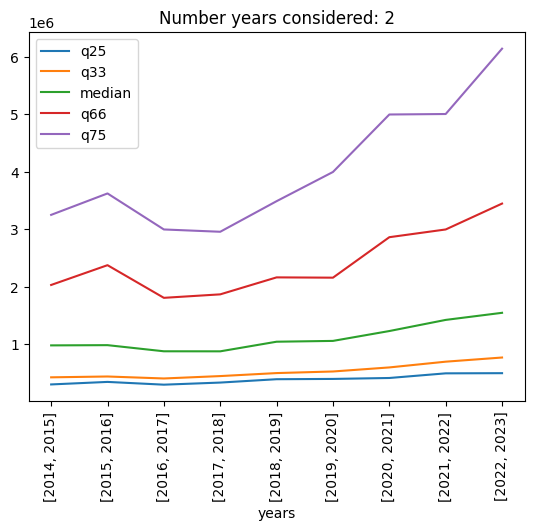

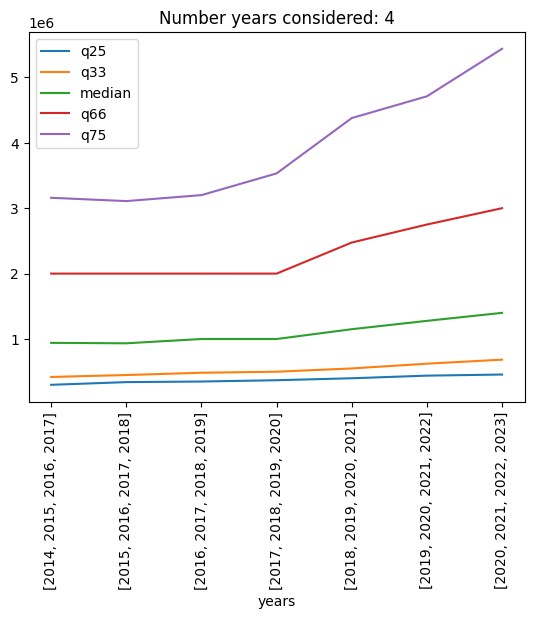

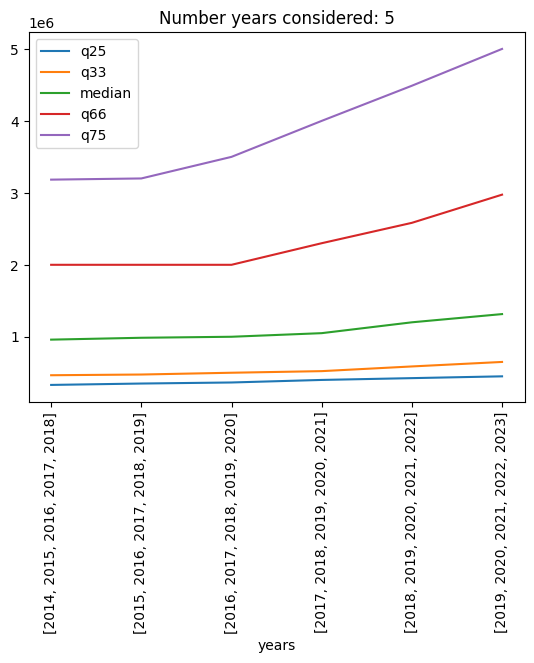

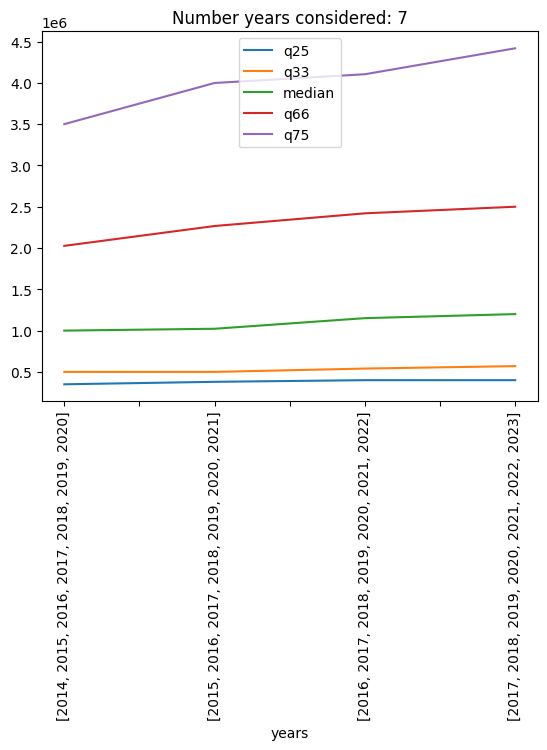

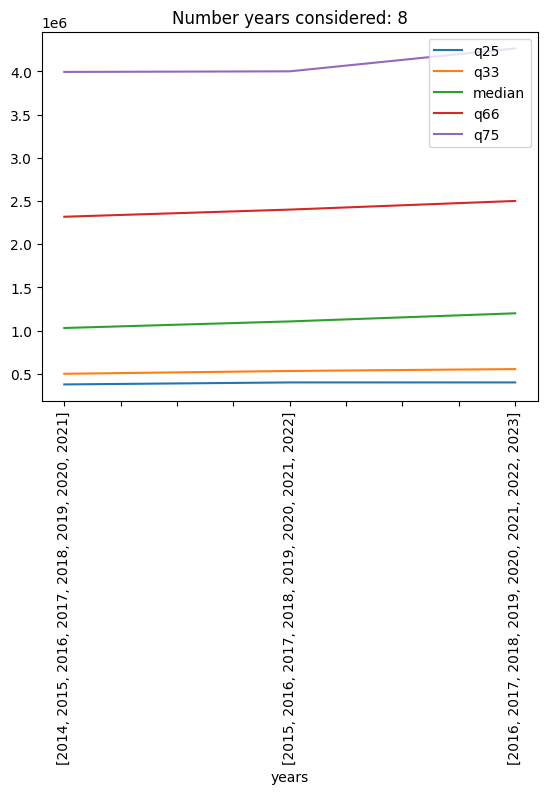

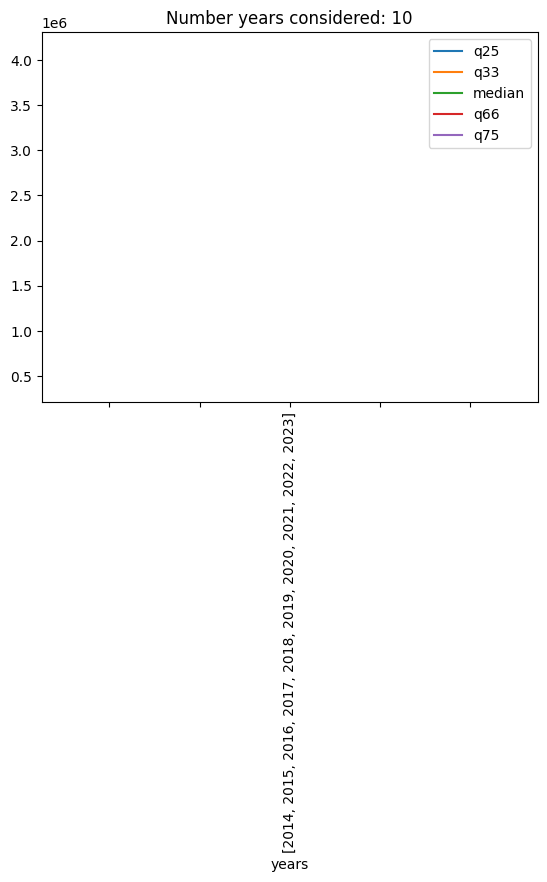

In [12]:
number_years = list(df_with_means["number_years"].unique())
for ye in number_years:
    df_with_means[df_with_means["number_years"]==ye].plot(title=f"Number years considered: {ye}", x="years", y=["q25", "q33", "median", "q66", "q75"], rot=90)

In [13]:
all_rez = []
for ye in range(len(years_in_dataset)):
    result_q25 = []
    result_q33 = []
    result_median = []
    result_q66 = []
    result_q75 = []
    pos = []

    temp_df = df_with_means[df_with_means["number_years"]==ye+1]
    q25_values = list(temp_df["q25"])
    q33_values = list(temp_df["q33"])
    qmed_values = list(temp_df["median"])
    q66_values = list(temp_df["q66"])
    q75_values = list(temp_df["q75"])
    pos = []
    for index, val in enumerate(q25_values):
        if index == 0:
            continue
        result_q25.append(abs(q25_values[index]-q25_values[index-1]))
        result_q33.append(abs(q33_values[index]-q33_values[index-1]))
        result_median.append(abs(qmed_values[index]-qmed_values[index-1]))
        result_q66.append(abs(q66_values[index]-q66_values[index-1]))
        result_q75.append(abs(q75_values[index]-q75_values[index-1]))
        pos.append(index)

    for i, _ in enumerate(result_q25):
        all_rez.append([pos[i], ye+1, result_q25[i], result_q33[i], result_median[i], result_q66[i], result_q75[i]])
cols = ['pos', 'number_years', 'diff_q25', 'diff_q33', 'diff_median', 'diff_q66', 'diff_q75']
df_with_diff = pd.DataFrame(data=all_rez, columns=cols)
df_with_diff.head(2)

pos  number_years  diff_q25     diff_q33   diff_median       diff_q66  \
0    1             1  18153.97  49947.50000   5000.000000  188349.902254   
1    2             1  55718.03  91512.78375  90866.666667  299712.891278   

        diff_q75  
0  431428.571429  
1  474682.539683

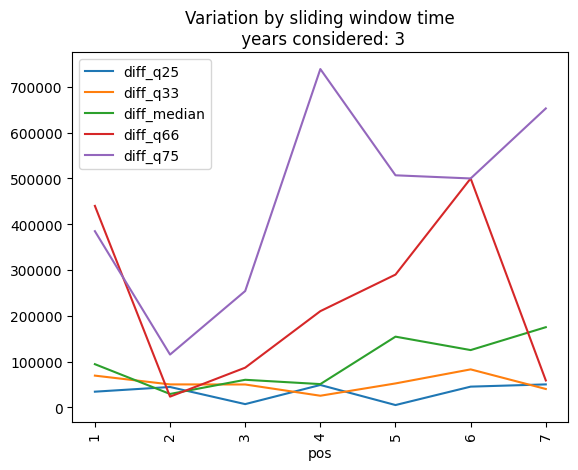

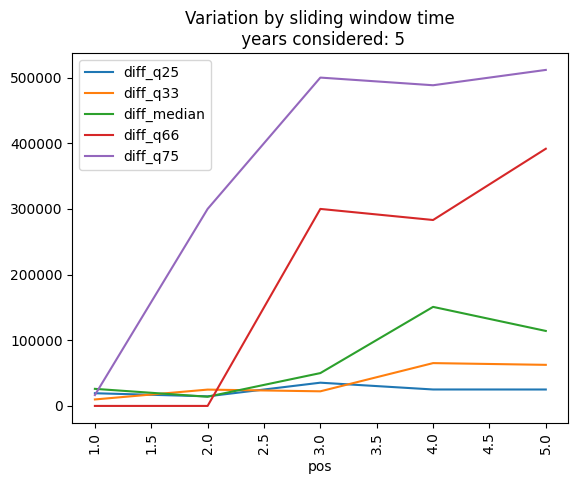

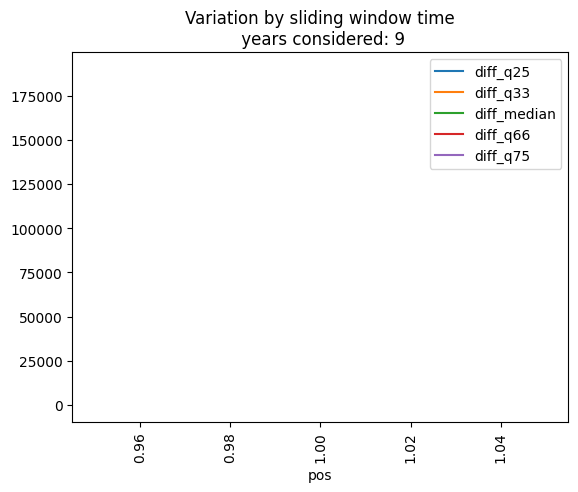

In [14]:
number_years = list(df_with_diff["number_years"].unique())
for ye in number_years:
    df_with_diff[df_with_diff["number_years"]==ye].plot(title=f"Variation by sliding window time\n years considered: {ye}", x="pos", y=["diff_q25", "diff_q33", "diff_median", "diff_q66", "diff_q75"], rot=90)

In [15]:
df_with_diff.groupby("number_years").mean()[["diff_q25","diff_q33", "diff_median", "diff_q66", "diff_q75"]].plot()

<Axes: xlabel='number_years'>

<Axes: xlabel='number_years'>

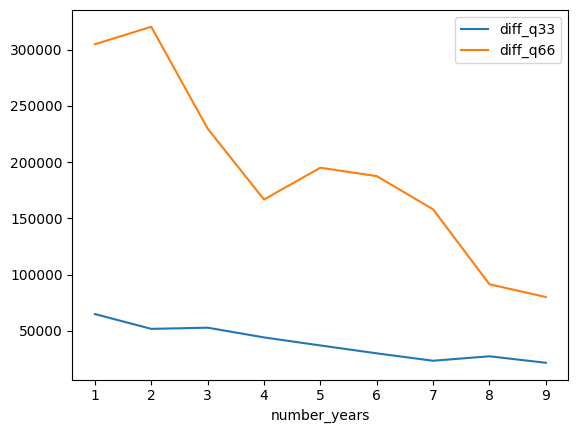

In [16]:
df_with_diff.groupby("number_years").mean()[["diff_q33", "diff_q66"]].plot()